In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms

from MuseGAN import Generator, Critic
from utils import load_music

from music21 import midi
from music21 import note, stream, duration
from music21 import converter

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [3]:
data_folder = '../data/chorales'
file_name = 'Jsb16thSeparated.npz'
output_folder = './output/muse_gan'
image_save_folder = './images/muse_gan'
model_save_path = './muse_gan.pth'

os.makedirs(output_folder, exist_ok=True)
os.makedirs(image_save_folder, exist_ok=True)

### 데이터 적재

In [4]:
n_bars = 2              # 마디 개수
n_steps_per_bar = 16    # 한 마디의 16분음표 개수
n_pitches = 84          # 음의 범위
n_tracks = 4            # 성부의 개수
z_dim = 32

data_binary, data_ints, raw_data = load_music(data_folder, file_name, n_bars, n_steps_per_bar)
data_binary = np.squeeze(data_binary)
print(data_binary.shape)

(229, 4, 2, 16, 84)


In [5]:
generator = Generator(z_dim, n_tracks, n_bars, n_steps_per_bar, n_pitches).to(device)
generator.eval()

loaded_models = torch.load(model_save_path, map_location=device)
generator.load_state_dict(loaded_models['Generator'])

<All keys matched successfully>

### 샘플 악보 보기

In [6]:
chords_noise = torch.randn(1, z_dim, device=device)
style_noise = torch.randn(1, z_dim, device=device)
melody_noise = torch.randn(1, n_tracks, z_dim, device=device)
groove_noise = torch.randn(1, n_tracks, z_dim, device=device)

In [7]:
gen_scores = generator(chords_noise, style_noise, melody_noise, groove_noise)

In [8]:
gen_scores = gen_scores.cpu().detach().numpy()

In [9]:
print(np.argmax(gen_scores[0, 0, 0, 0:4, :], axis=1))

[67 67 67 67]


In [10]:
# gen_scores[0, 3, 0, 0:4, 60] = 0.02347812

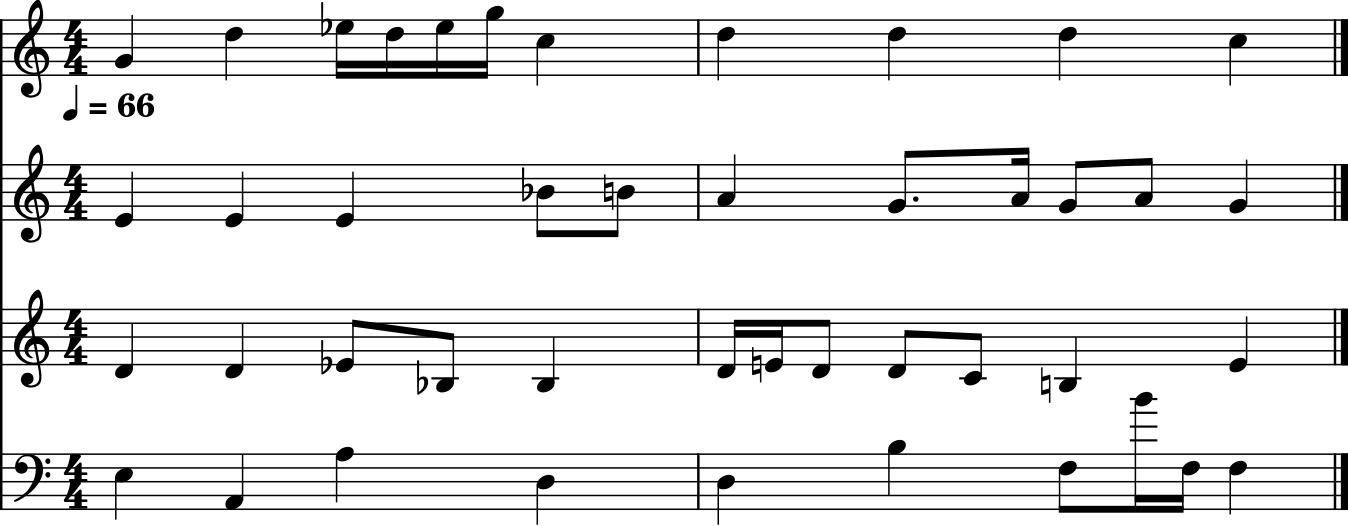

In [11]:
filename = 'example.midi'
file_path = os.path.join(output_folder, filename)
generator.notes_to_midi(file_path, gen_scores)
gen_score = converter.parse(file_path)
gen_score.show()

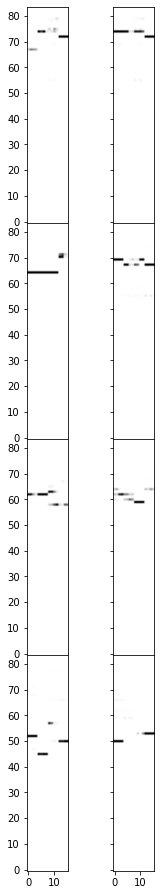

In [12]:
generator.draw_score(gen_scores, 0)

### 가장 가까운 악보 찾기

In [13]:
def find_closest(data_binary, score):
    current_dist = 99999999
    current_i = -1
    for i, d in enumerate(data_binary):
        dist = np.sqrt(np.sum(pow((d - score), 2)))
        if dist < current_dist:
            current_i = i
            current_dist = dist

    return current_i

In [14]:
closest_idx = find_closest(data_binary, gen_scores[0])
closest_data = data_binary[[closest_idx]]
print(closest_idx)

117


생성된 악보


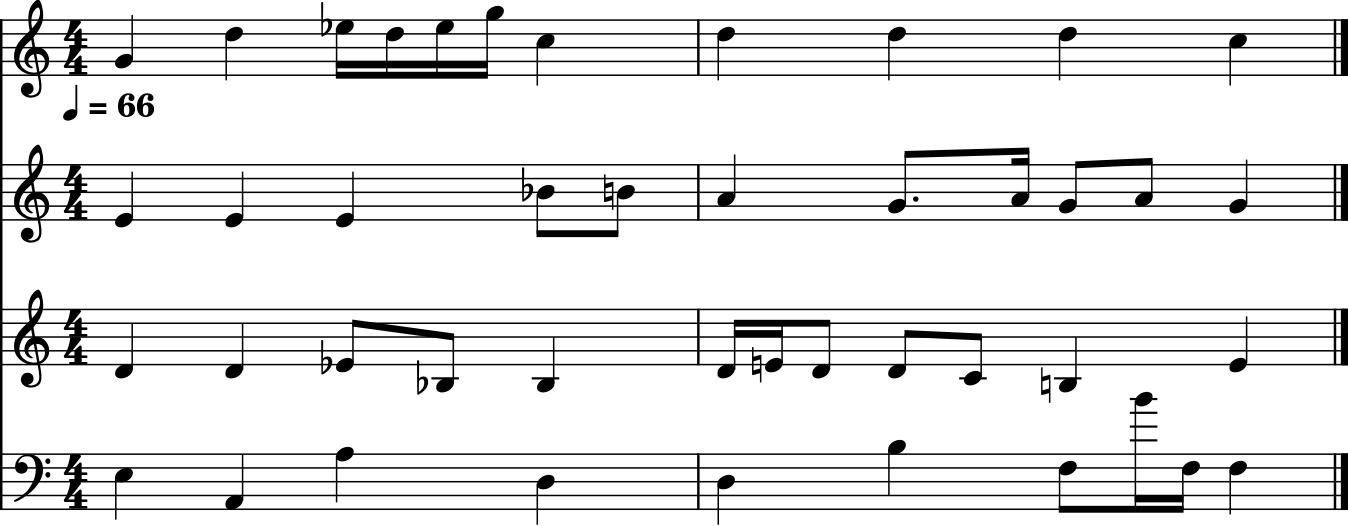

가장 가까운 악보


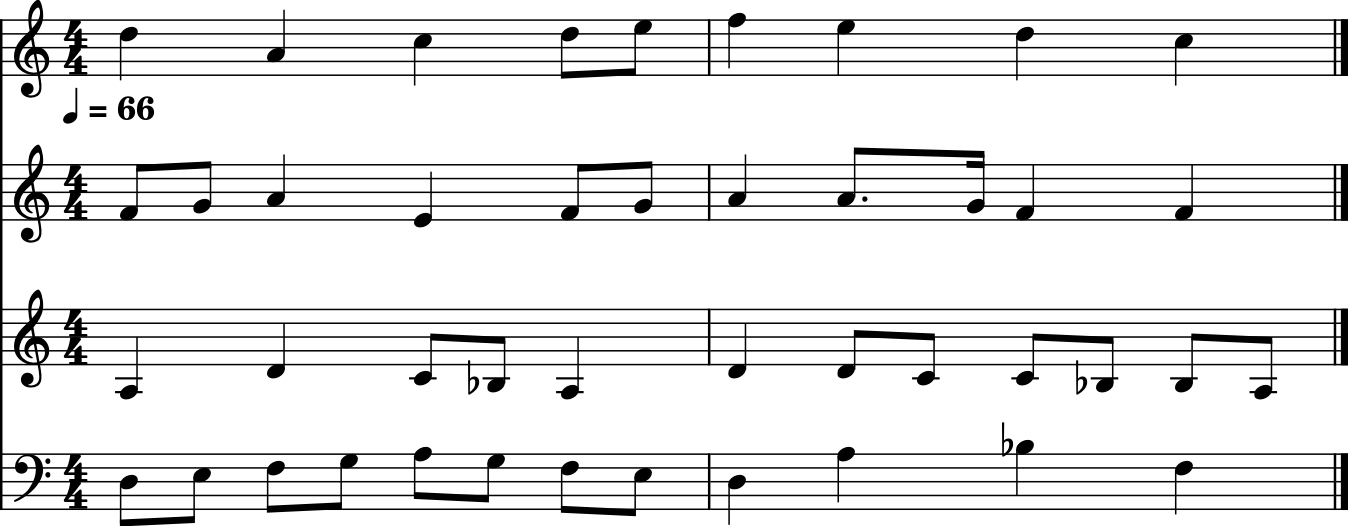

In [15]:
filename = 'closest.midi'
filepath = os.path.join(output_folder, filename)
generator.notes_to_midi(filepath, closest_data)
closest_score = converter.parse(filepath)
print('생성된 악보')
gen_score.show()
print('가장 가까운 악보')
closest_score.show()

### 화음 잡음 바꾸기

In [16]:
chords_noise_2 = 5 * torch.ones((1, z_dim))

In [17]:
chords_scores = generator(chords_noise_2, style_noise, melody_noise, groove_noise)
chords_scores = chords_scores.detach().numpy()

생성된 악보


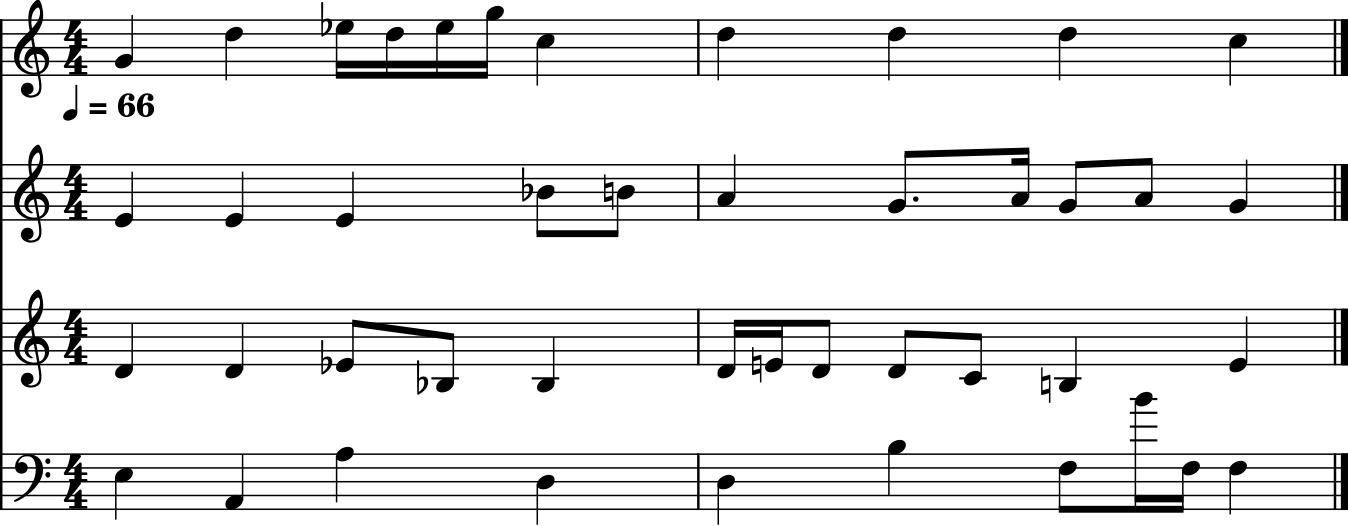

화음 잡음 변경


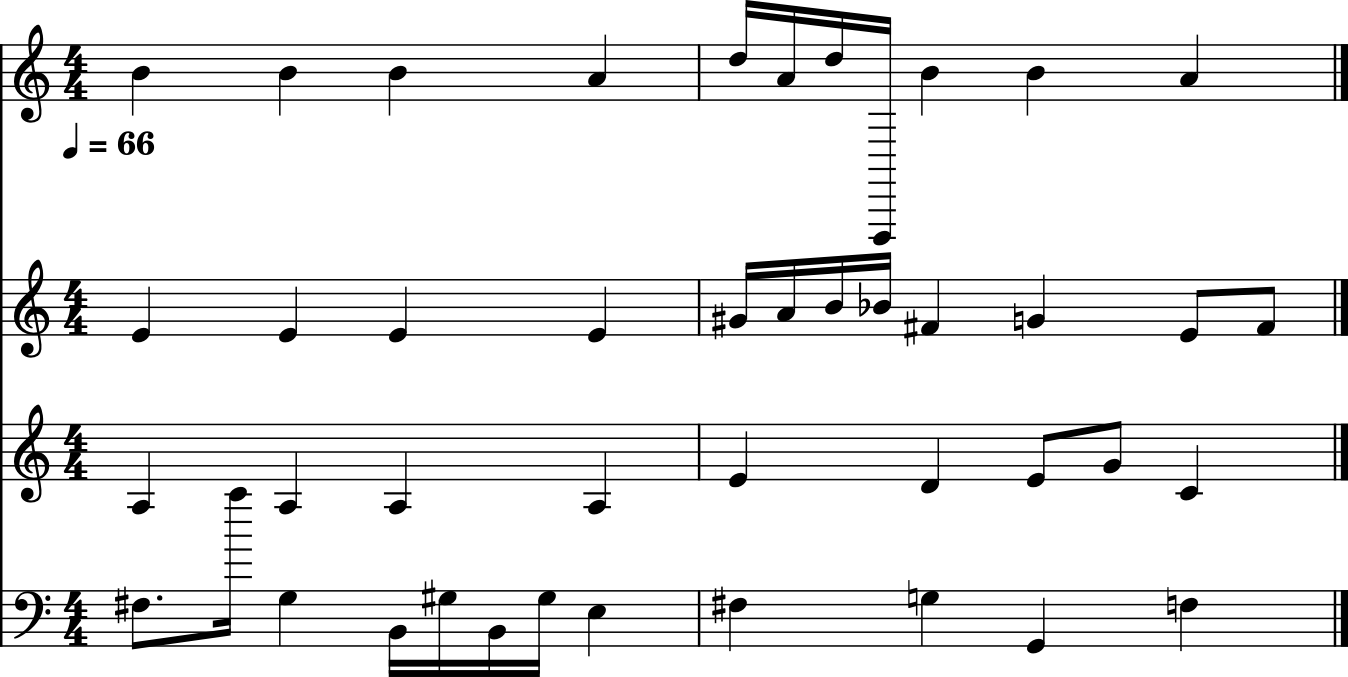

In [19]:
filename = 'changing_chords.midi'
filepath = os.path.join(output_folder, filename)
generator.notes_to_midi(filepath, chords_scores)
chords_score = converter.parse(filepath)
print('생성된 악보')
gen_score.show()
print('화음 잡음 변경')
chords_score.show()

### 스타일 잡음 바꾸기

In [20]:
style_noise_2 = 5 * torch.ones((1, z_dim))

In [21]:
style_scores = generator(chords_noise, style_noise_2, melody_noise, groove_noise)
style_scores = style_scores.detach().numpy()

생성된 악보


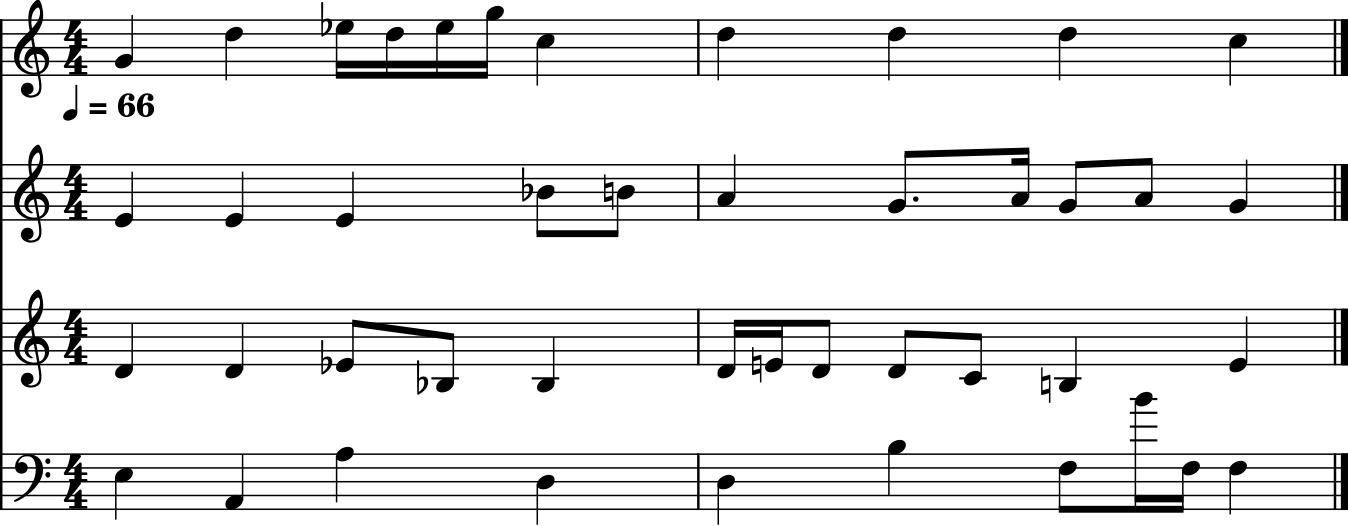

스타일 잡음 변경


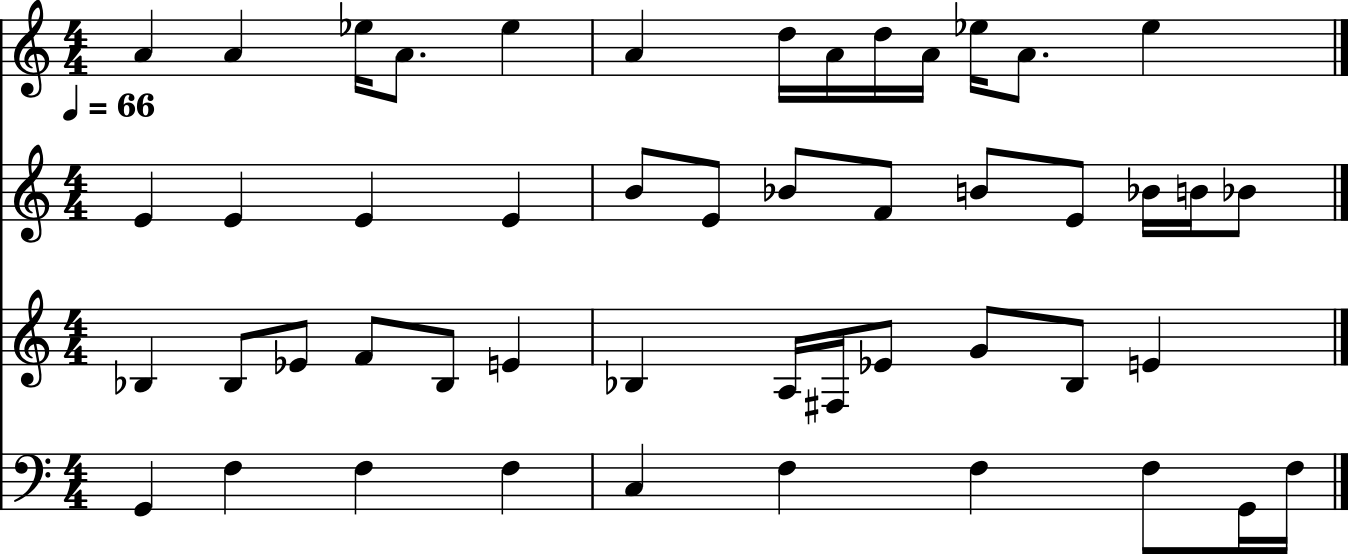

In [22]:
filename = 'changing_style.midi'
filepath = os.path.join(output_folder, filename)
generator.notes_to_midi(filepath, style_scores)
style_score = converter.parse(filepath)
print('생성된 악보')
gen_score.show()
print('스타일 잡음 변경')
style_score.show()

### 멜로디 잡음 바꾸기

In [23]:
melody_noise_2 = melody_noise.clone()
melody_noise_2[0, 0, :] = 5 * torch.ones(z_dim)

In [24]:
melody_scores = generator(chords_noise, style_noise, melody_noise_2, groove_noise)
melody_scores = melody_scores.detach().numpy()

생성된 악보


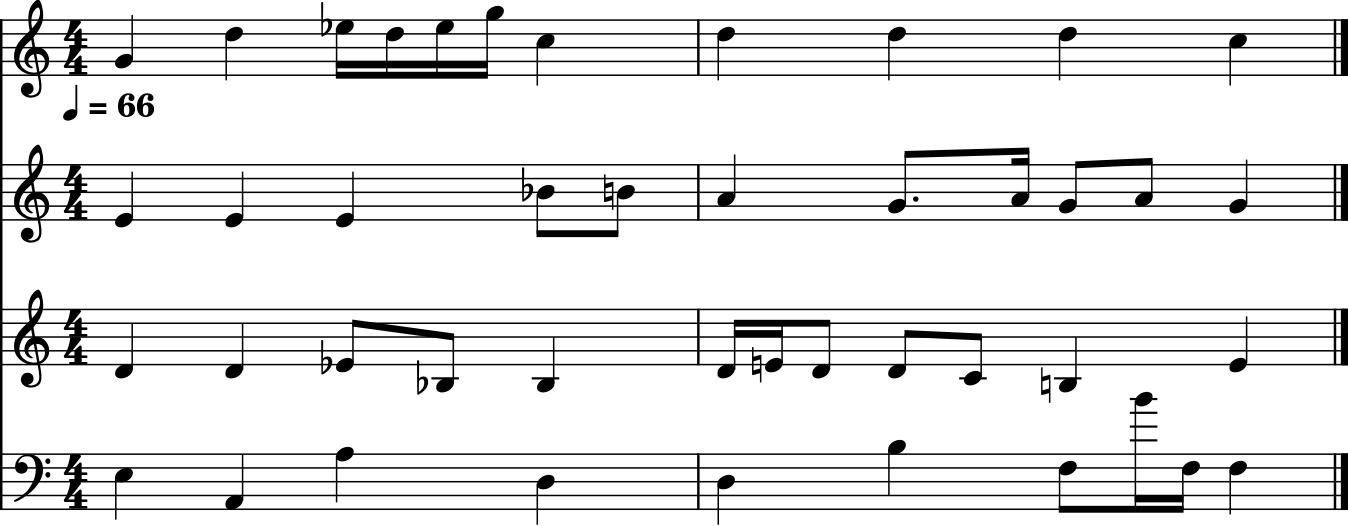

멜로디 잡음 변경


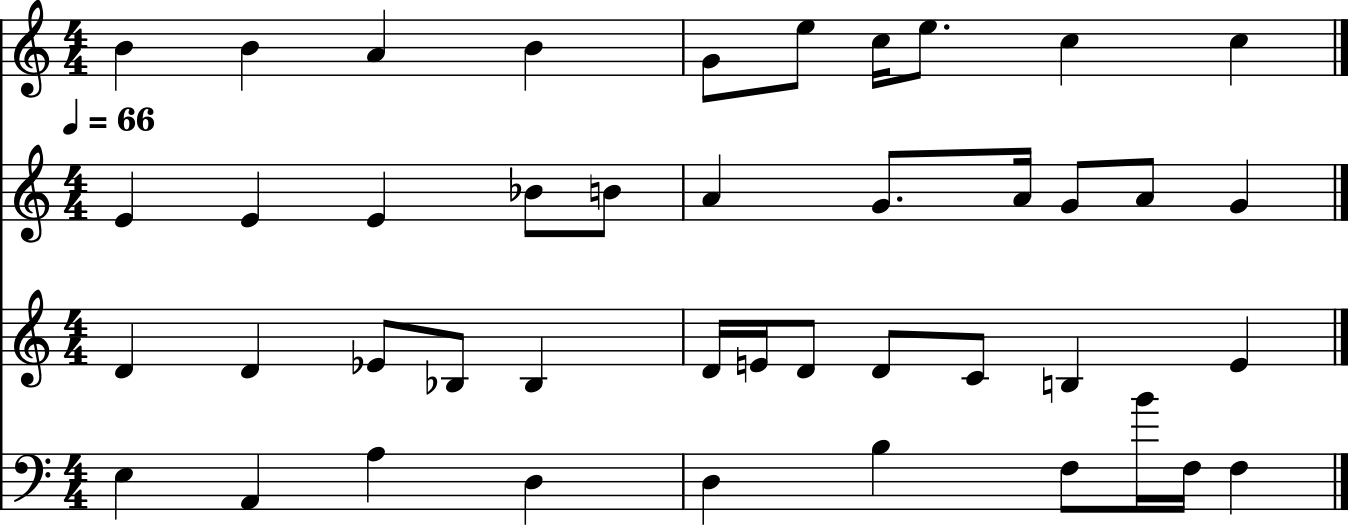

In [25]:
filename = 'changing_melody.midi'
filepath = os.path.join(output_folder, filename)
generator.notes_to_midi(filepath, melody_scores)
melody_score = converter.parse(filepath)
print('생성된 악보')
gen_score.show()
print('멜로디 잡음 변경')
melody_score.show()

### 리듬(그루브) 잡음 바꾸기

In [29]:
groove_noise_2 = groove_noise.clone()
groove_noise_2[0, 3, :] = 5 * torch.ones(z_dim)

In [30]:
groove_scores = generator(chords_noise, style_noise, melody_noise, groove_noise_2)
groove_scores = groove_scores.detach().numpy()

생성된 악보


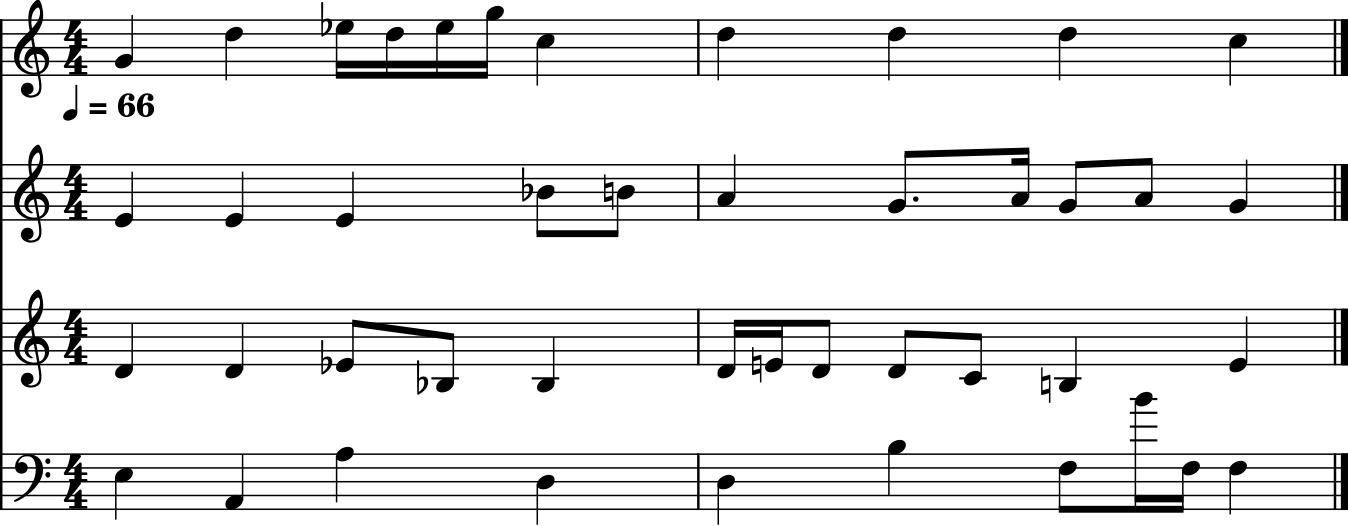

그루브 잡음 변경


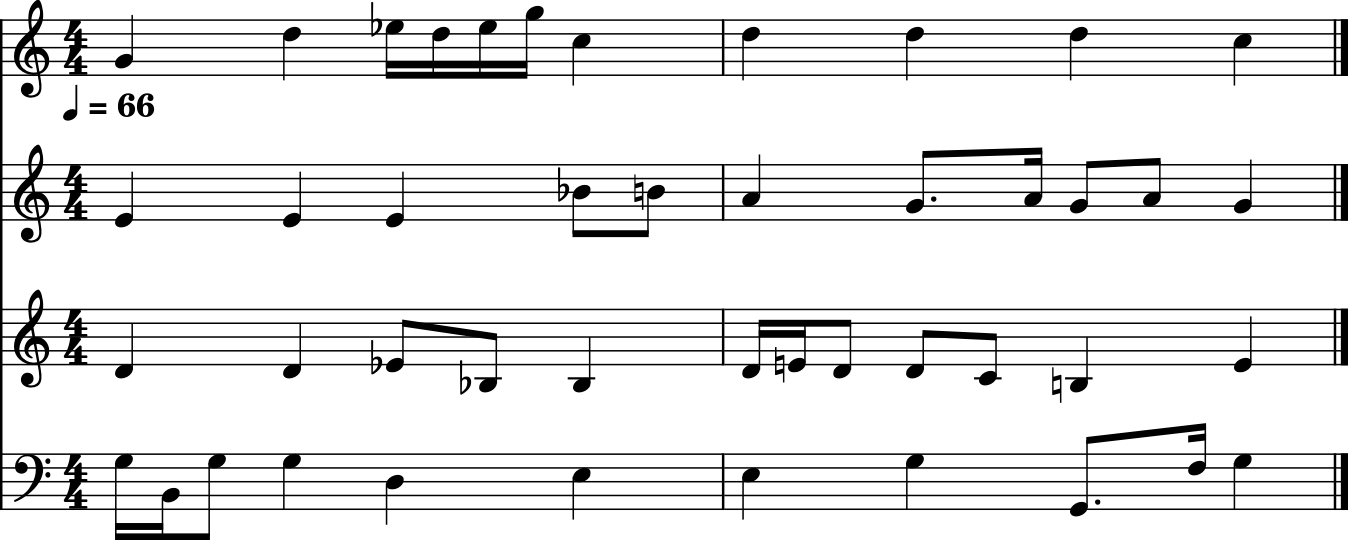

In [31]:
filename = 'changing_groove.midi'
filepath = os.path.join(output_folder, filename)
generator.notes_to_midi(filepath, groove_scores)
groove_score = converter.parse(filepath)
print('생성된 악보')
gen_score.show()
print('그루브 잡음 변경')
groove_score.show()